
# Exploring Ghana's Milk Import and Export for Jan-May,2019

A country's economy depends, sometimes heavily, on its exports and imports. The United Nations Comtrade database provides data on global trade. It will be used to analyse the Ghana's imports and exports of milk and cream in January to May 2019:

1. How much does the Ghana export and import and is the balance positive (more exports than imports)?
2. Which are the main trading partners, i.e. from/to which countries does the Ghana import/export the most?
3. Which are the regular customers, i.e. which countries buy milk from Ghana every month?
4. Which countries does Ghana both import from and export to?

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

# Getting and preparing the data

The data is obtained from the United Nations Comtrade website, by selecting the following configuration:

    Type of Product: goods
    Frequency: monthly
    Periods: January to May of 2019
    Reporter: Ghana
    Partners: all
    Flows: imports and exports
    HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)

In [2]:
LOCATION = 'Comtrade_milk_ghana.csv'

On reading in the data, the commodity code has to be read as a string, to not lose the leading zero

In [7]:
import pandas as pd
milk = pd.read_csv(LOCATION, dtype={'Commodity Code':str})
milk.tail(2)

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
235,HS,2019,201902,February 2019,4,0,2,Exports,288,Ghana,...,NaN,NaN,NaN,NaN,23811,NaN,132646,NaN,NaN,0
236,HS,2019,201905,May 2019,4,0,1,Imports,288,Ghana,...,NaN,NaN,NaN,NaN,96754,NaN,118768,NaN,NaN,0


The data only covers the first five months of 2019. Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [8]:
def milkType(code):
    if code == '401': # neither concentrated nor sweetened
        return 'unprocessed'
    if code == '402': # concentrated or sweetened
        return 'processed' 
    return 'unknown'

COMMODITY = 'Milk and cream'
milk[COMMODITY] = milk['Commodity Code'].apply(milkType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
milk = milk[headings]
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
0,201901,World,Imports,unknown,348023
1,201901,World,Exports,unknown,12
2,201901,Australia,Imports,unknown,38
3,201901,Belgium,Imports,unknown,91978
4,201901,Canada,Imports,unknown,56


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [9]:
milk = milk[milk[PARTNER] != 'World']
milk.head()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
2,201901,Australia,Imports,unknown,38
3,201901,Belgium,Imports,unknown,91978
4,201901,Canada,Imports,unknown,56
5,201901,Costa Rica,Exports,unknown,12
6,201901,France,Imports,unknown,112426


In [10]:
milk.tail()

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)
232,201902,Côte d'Ivoire,Exports,unknown,75596
233,201902,Japan,Exports,unknown,50
234,201902,Liberia,Exports,unknown,104789
235,201902,Burkina Faso,Exports,unknown,132646
236,201905,France,Imports,unknown,118768


# Total trade flow

To answer question 1, 'how much does Ghana export and import and is the balance positive (more exports than imports)?',

The dataframe is split into two groups: exports from the Uganda and imports into the Uganda. 
The trade values within each group are summed up to get the total trading.

In [11]:
grouped = milk.groupby([FLOW])
grouped[VALUE].aggregate(sum)

Trade Flow
Exports     4584691
Imports    29410329
Name: Trade Value (US$), dtype: int64

In [ ]:
This shows a Trade Deficit of over 24 million USD. Hence, it is a negative balance, where the imports are more than the exports.

# Main trade partners

To address question 2, 'Which are the main trading partners, i.e. from/to which countries does the Ghana import/export the most?', 

The dataframe is split by country instead, and then each group aggregated for the total trade value. 
This is done separately for imports and exports. 
The result is sorted in descending order so that the main partners are at the top.



In [13]:
imports = milk[milk[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('Ghana imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to Ghana are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports.head()

Ghana imports from 50 countries.
The 5 biggest exporters to Ghana are:


Partner
Nigeria        5115393
New Zealand    4804116
Ireland        2778598
Poland         2640685
Belgium        2053128
Name: Trade Value (US$), dtype: int64

The values will be plotted as a bar chart, making the differences between countries much easier to visualise

<AxesSubplot:ylabel='Partner'>

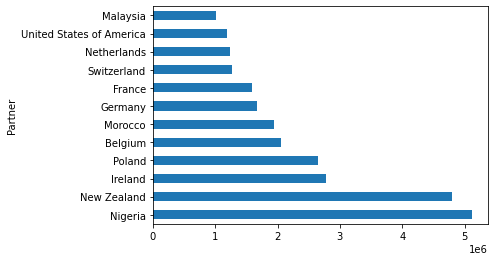

In [15]:
totalImports.head(12).plot(kind='barh')

In [19]:
exports = milk[milk[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('Ghana exports to', len(grouped), 'countries.')
print('The 5 biggest importers from Ghana are:')
totalExports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalExports.head()

Ghana exports to 11 countries.
The 5 biggest importers from Ghana are:


Partner
Senegal          2199237
Burkina Faso     1539342
Côte d'Ivoire     408982
Mali              225800
Liberia           171349
Name: Trade Value (US$), dtype: int64

The values will be plotted as a bar chart, making differences between countries easier to visualise

<AxesSubplot:ylabel='Partner'>

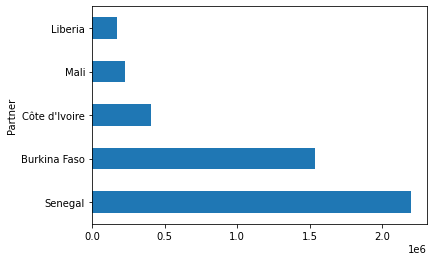

In [21]:
totalExports.head(5).plot(kind='barh')

# Regular importers

Given that there are two commodities, question 3, 

'Which are the regular customers, i.e. which countries buy milk from Ghana every month?', is meant in the sense that a regular customer imports both commodities every month. This means that if the exports dataframe is grouped by country, each group has exactly ten rows (two commodities bought each of the five months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [22]:
def buysEveryMonth(group):
    return len(group) == 10

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular[(regular[MONTH] == 201501) & (regular[COMMODITY] == 'processed')]

,Period,Partner,Trade Flow,Milk and cream,Trade Value (US$)


In [23]:
regular[VALUE].sum() / exports[VALUE].sum()

0.0

# Bi-directional trade

To address question 4, 'Which countries does the Ghana both import from and export to?', a pivot table is used to list the total export and import value for each country.

In [24]:
countries = pivot_table(milk, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries.head()

Trade Flow,Exports,Imports
Partner,,
American Samoa,NaN,13.0
Australia,NaN,524.0
Austria,NaN,78.0
Belgium,NaN,2053128.0
Burkina Faso,1539342.0,28.0


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with the UK.

In [25]:
countries.dropna()

Trade Flow,Exports,Imports
Partner,,
Burkina Faso,1539342.0,28.0
Côte d'Ivoire,408982.0,2204.0
Japan,94.0,24.0
Liberia,171349.0,26.0
Senegal,2199237.0,338.0
South Africa,131.0,20203.0
United Kingdom,1446.0,750016.0
United States of America,2467.0,1188281.0


The milk and cream trade of Ghana from January to May 2019 was analysed in terms of which countries that Ghana mostly depends on for income (exports) and goods (imports). Over the period, Ghana  had a trade deficit of over 24 million US dollars. Which was for the fact that the imports were more than the exports.

Nigeria is the main partner in the sense that it imported from Nigeria about 5 million USD. Followed by New Zealand and then Ireland.
Ghana exported to only 11 countries during the period, but then imported from 50 countries, the main ones (top five by trade value) being geographically close. Nigeria is the main exporter to Ghana and then Ghana doesnt export to them.

Ghana do not have regular customers, they do not have regular countries that buy all types of milk and cream every month. 

Ghana has bi-directional trade (i.e. both exports and imports) with 8 countries, although for some the trade value (in US dollars) is suspiciously low, which raises questions about the data's accuracy.